In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'neuralClosureModels'))

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.bio_eqn_case.bio_eqn_modcall as bio
from src.bio_eqn_case.Bio_Eqn_Helper_Classes import * 

import time
from math import *
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32')

## NPZ Model

In [4]:
app = bio.bio_eqn_args(T = 30.*2, nt = 600*2, z = -25, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., 
                            Psi = 1.46, Xi = 0.1, R_m = 1.52, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, 
                            Omega = 0.041, T_bio = 30., bio_model = 'NPZ')

x0 = initial_cond(app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

In [5]:
x_npz = ddeinttf(bio.bio_eqn(app), x0, t, alg_name = 'dopri5', nsteps = 5)

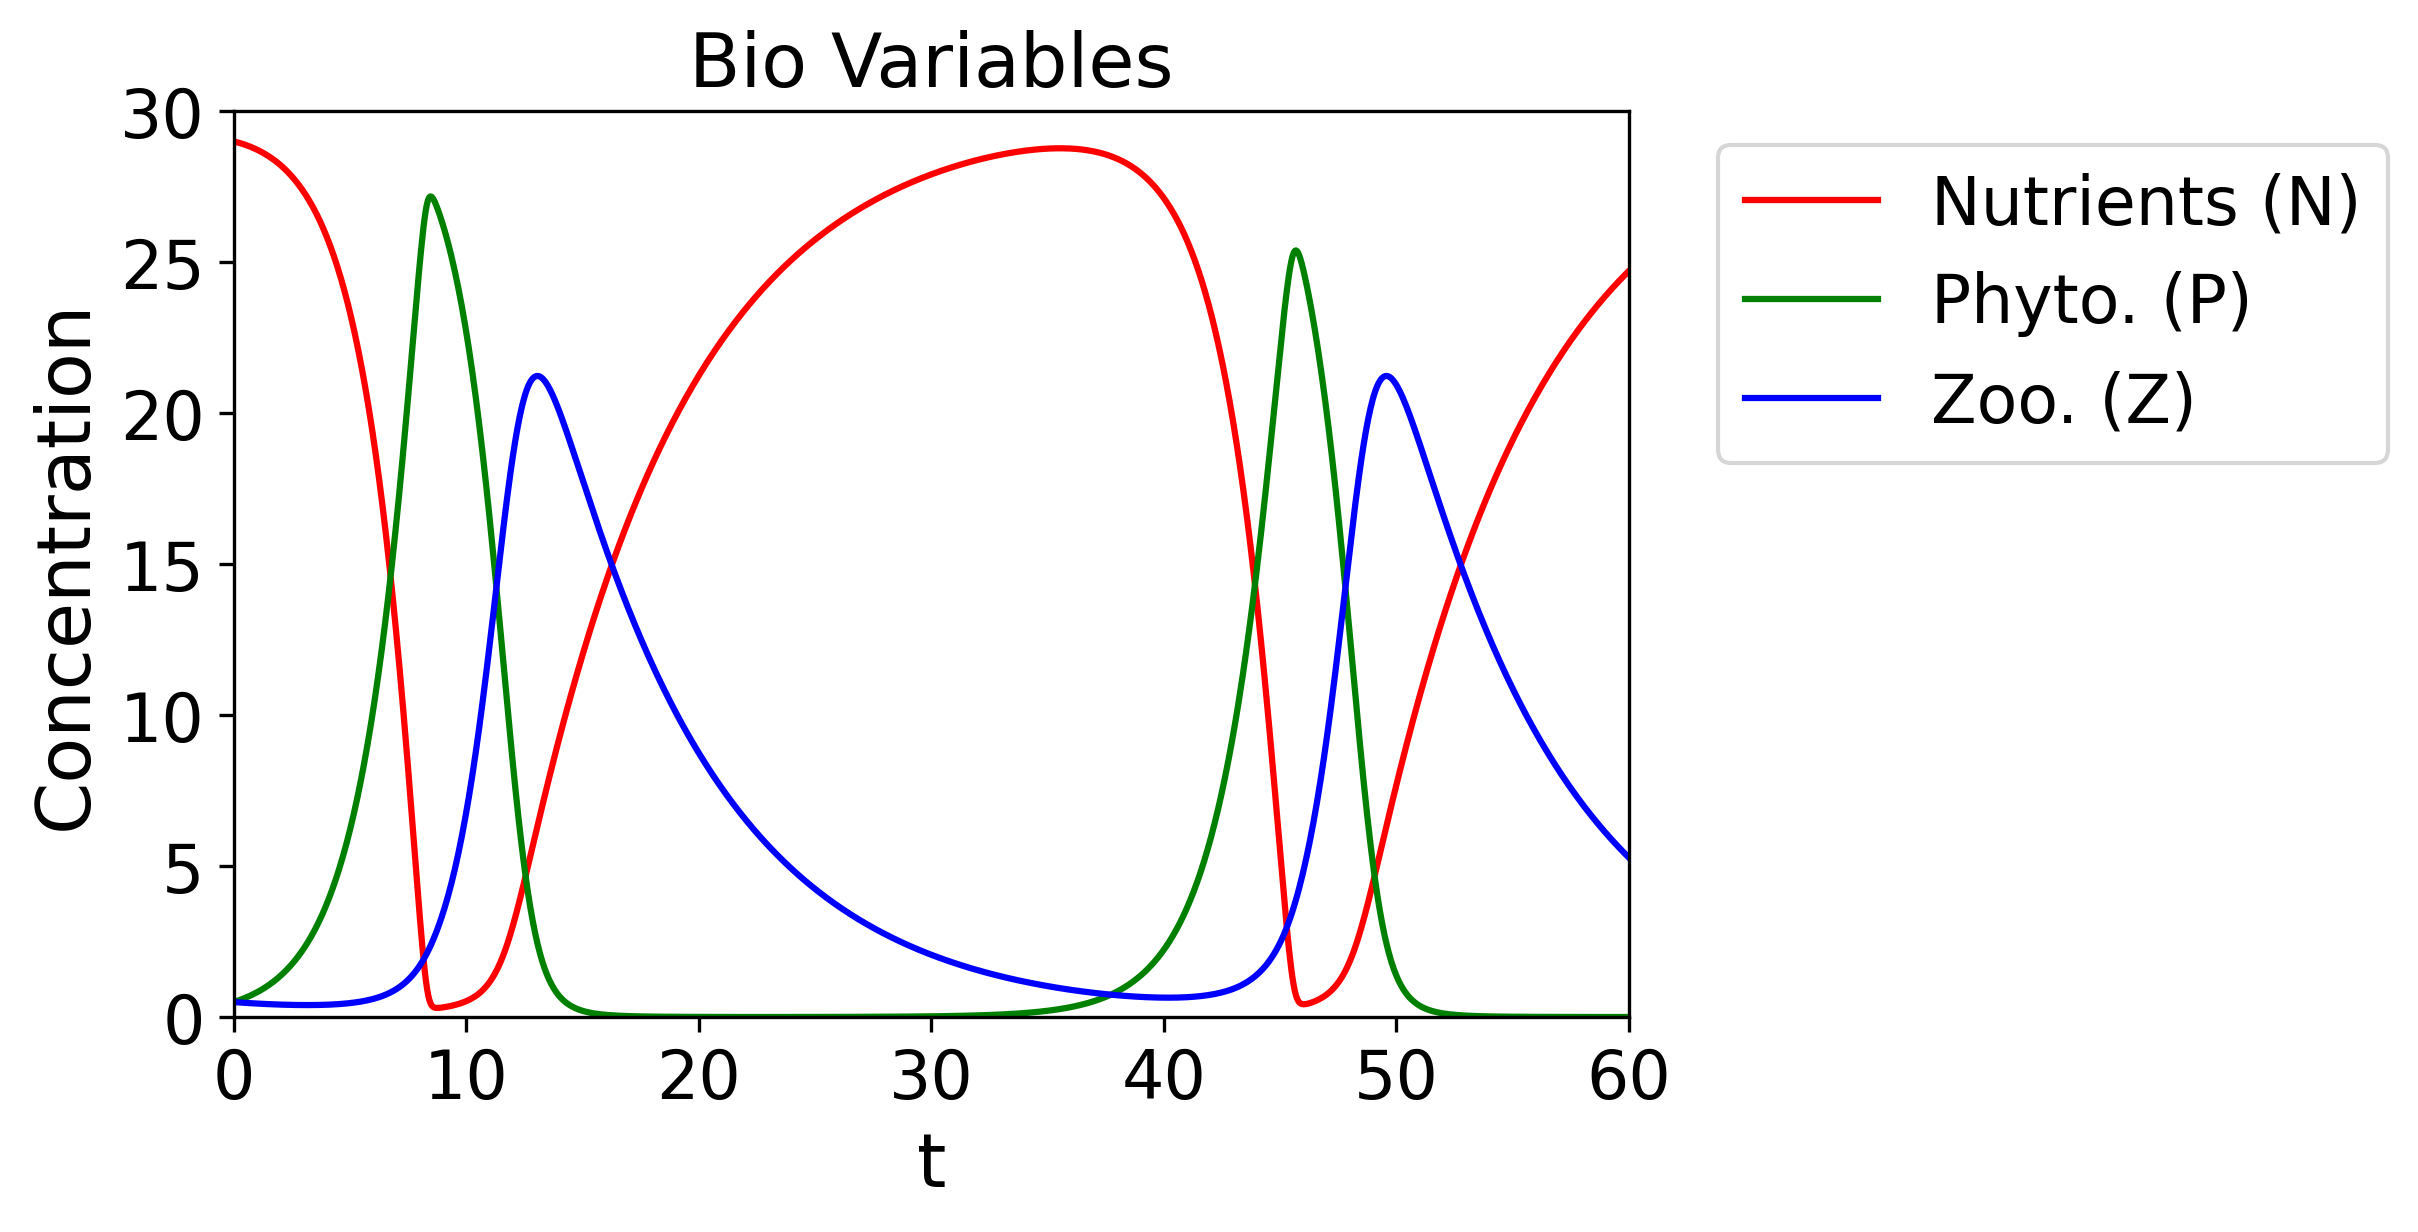

In [6]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Variables', fontsize=18)
ax_x1.set_xlabel('t', fontsize=18)
ax_x1.set_ylabel('Concentration', fontsize=18)
ax_x1.plot(t.numpy(), x_npz[:, 0, 0], '-r', label = 'Nutrients (N)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 1], '-g', label = 'Phyto. (P)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 2], '-b', label = 'Zoo. (Z)')
ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 16})
ax_x1.tick_params(axis='x', labelsize=16)
ax_x1.tick_params(axis='y', labelsize=16)

plt.gcf().set_dpi(300)
plt.show()

## NNPZD Model

In [7]:
app = bio.bio_eqn_args(T = 30.*2, nt = 600*2, z = -25, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., 
                            Psi = 1.46, Xi = 0.1, R_m = 1.52, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, 
                            Omega = 0.041, T_bio = 30., bio_model = 'NNPZD')

x0 = initial_cond(app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

In [8]:
x_nnpzd = ddeinttf(bio.bio_eqn(app), x0, t, alg_name = 'dopri5', nsteps = 5)

/home/abhinavgupta0110/.local/lib/python3.8/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


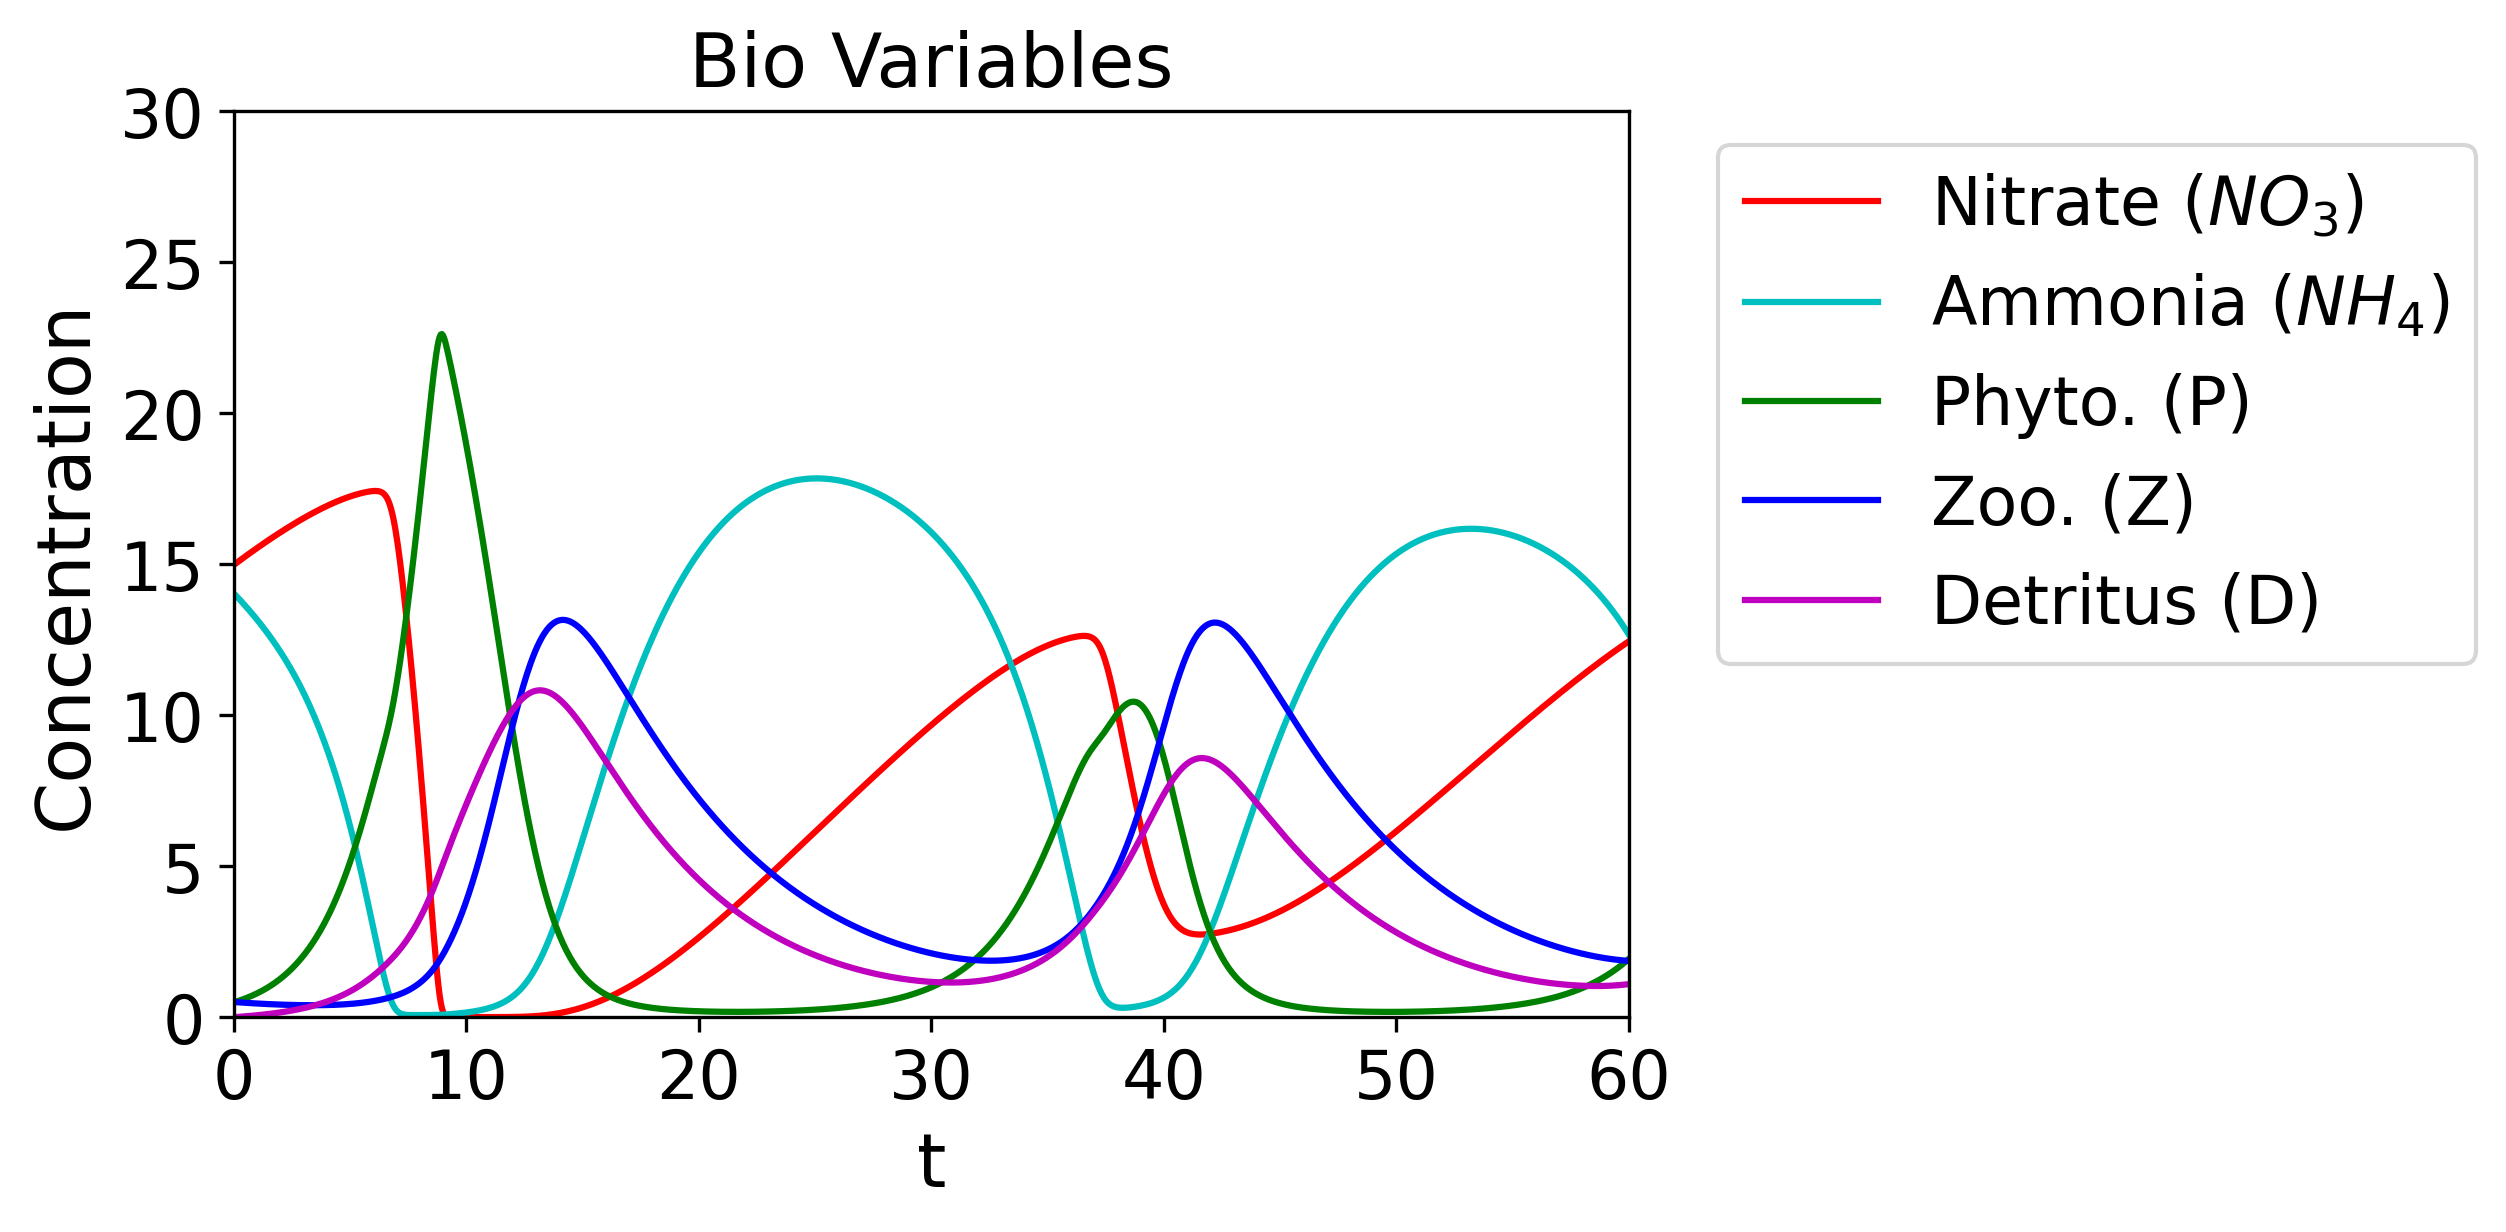

In [9]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Variables', fontsize=18)
ax_x1.set_xlabel('t', fontsize=18)
ax_x1.set_ylabel('Concentration', fontsize=18)
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 0], '-r', label = 'Nitrate ($NO_3$)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 1], '-c', label = 'Ammonia ($NH_4$)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 2], '-g', label = 'Phyto. (P)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 3], '-b', label = 'Zoo. (Z)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 4], '-m', label = 'Detritus (D)')
ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 16})
ax_x1.tick_params(axis='x', labelsize=16)
ax_x1.tick_params(axis='y', labelsize=16)

plt.gcf().set_dpi(300)
plt.show()

## Plot and compare aggregated variables

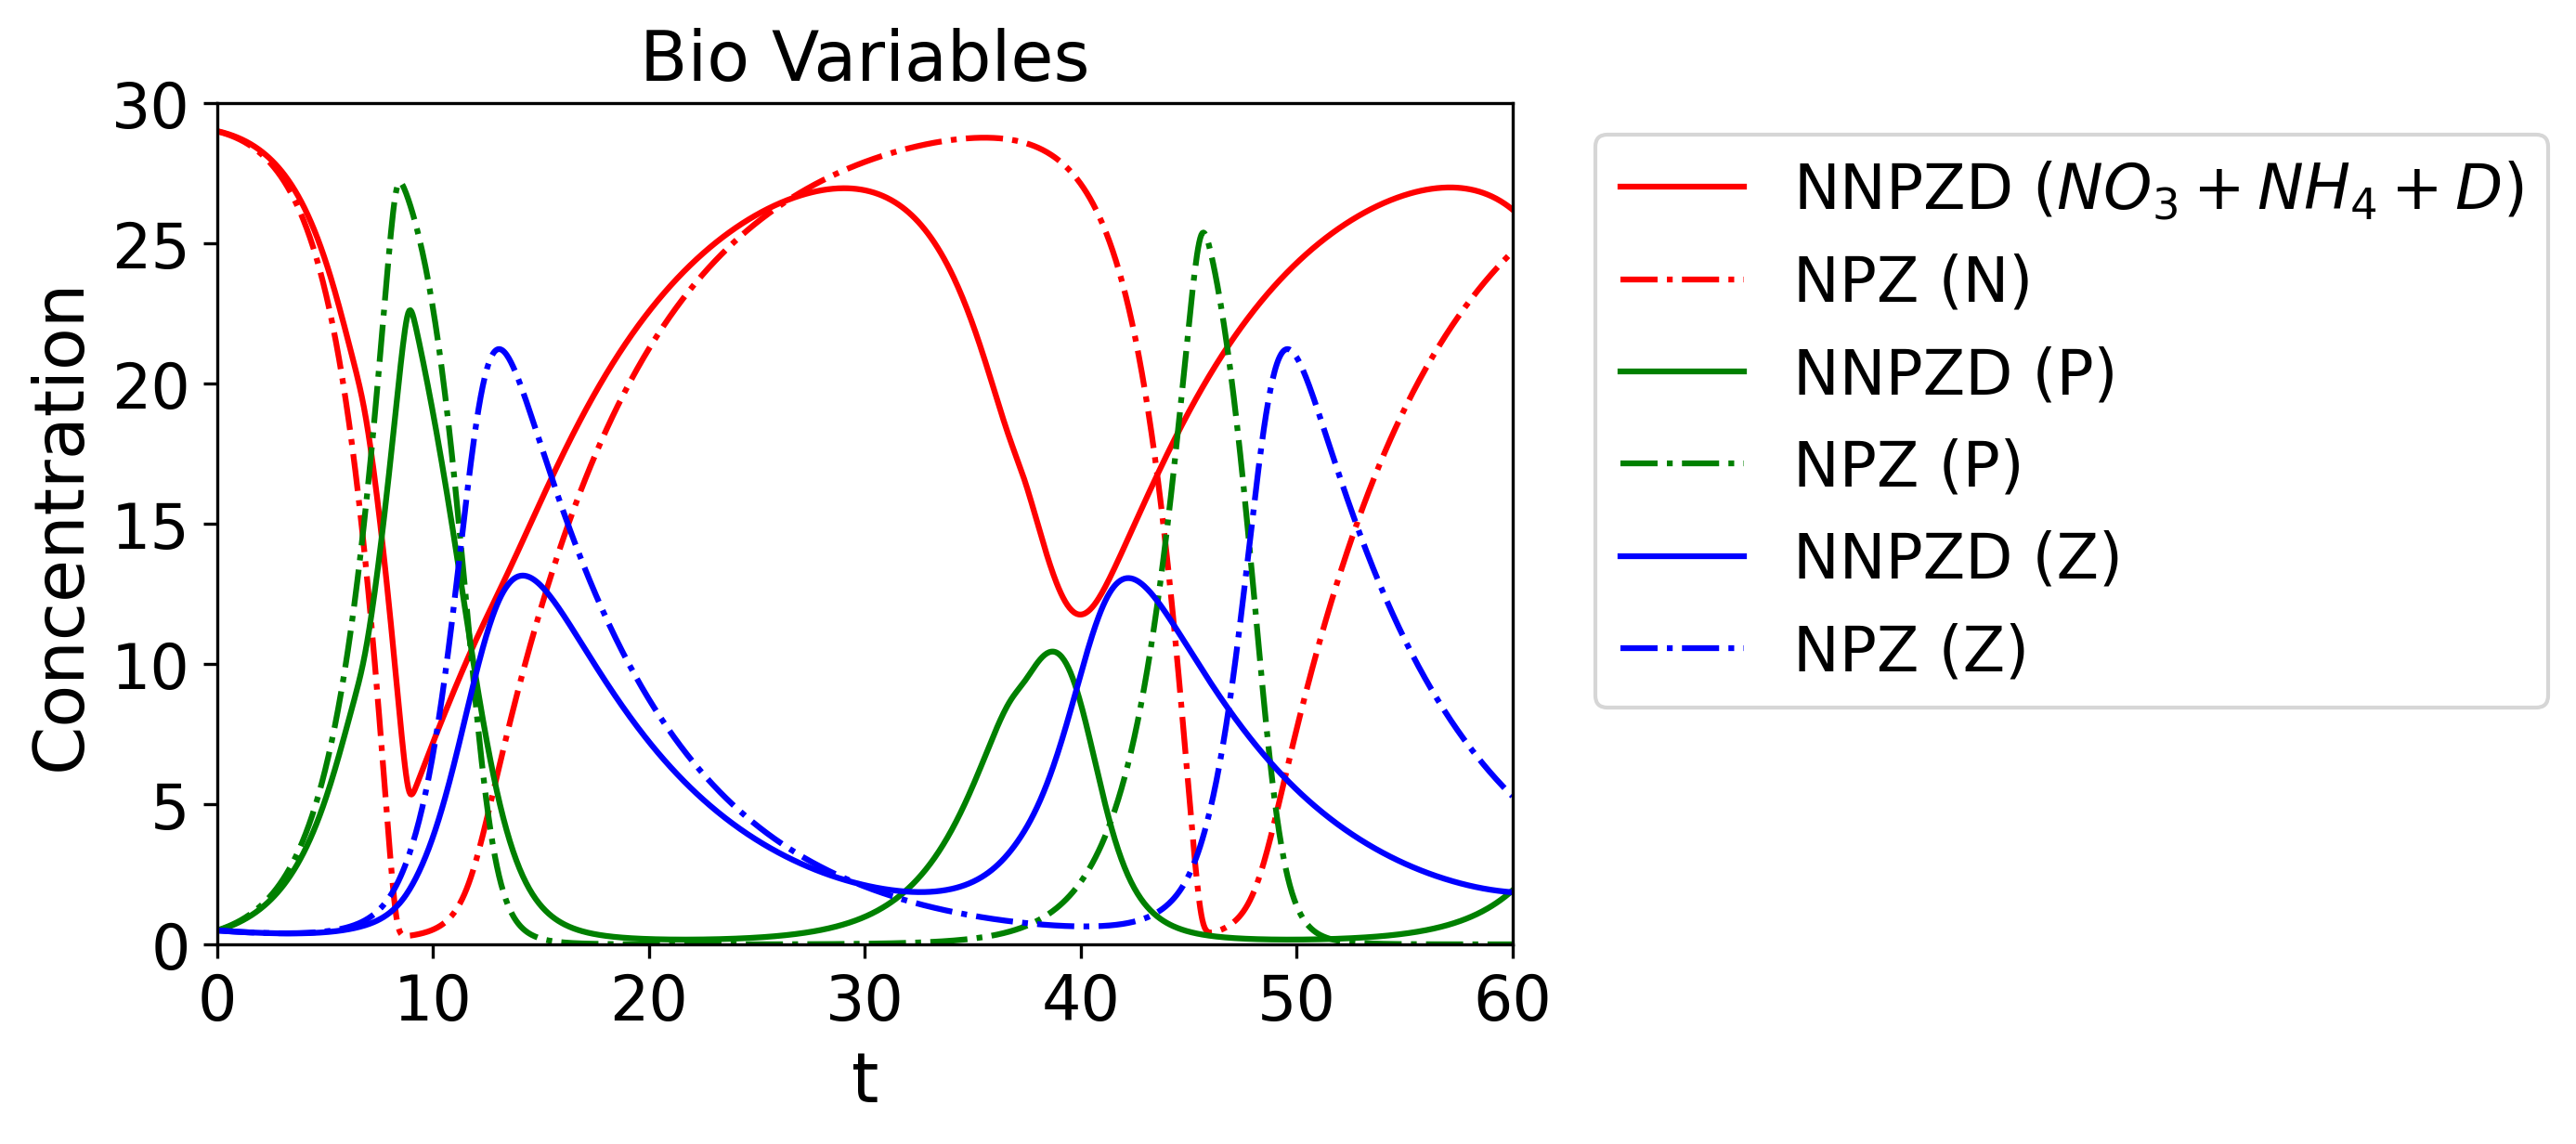

In [10]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Variables', fontsize=18)
ax_x1.set_xlabel('t', fontsize=18)
ax_x1.set_ylabel('Concentration', fontsize=18)
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 0] + x_nnpzd[:, 0, 1] + x_nnpzd[:, 0, 4], '-r', label = 'NNPZD ($NO_3 + NH_4 + D$)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 0], '-.r', label = 'NPZ (N)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 2], '-g', label = 'NNPZD (P)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 1], '-.g', label = 'NPZ (P)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 3], '-b', label = 'NNPZD (Z)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 2], '-.b', label = 'NPZ (Z)')
ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 16})
ax_x1.tick_params(axis='x', labelsize=16)
ax_x1.tick_params(axis='y', labelsize=16)

plt.gcf().set_dpi(300)
plt.show()

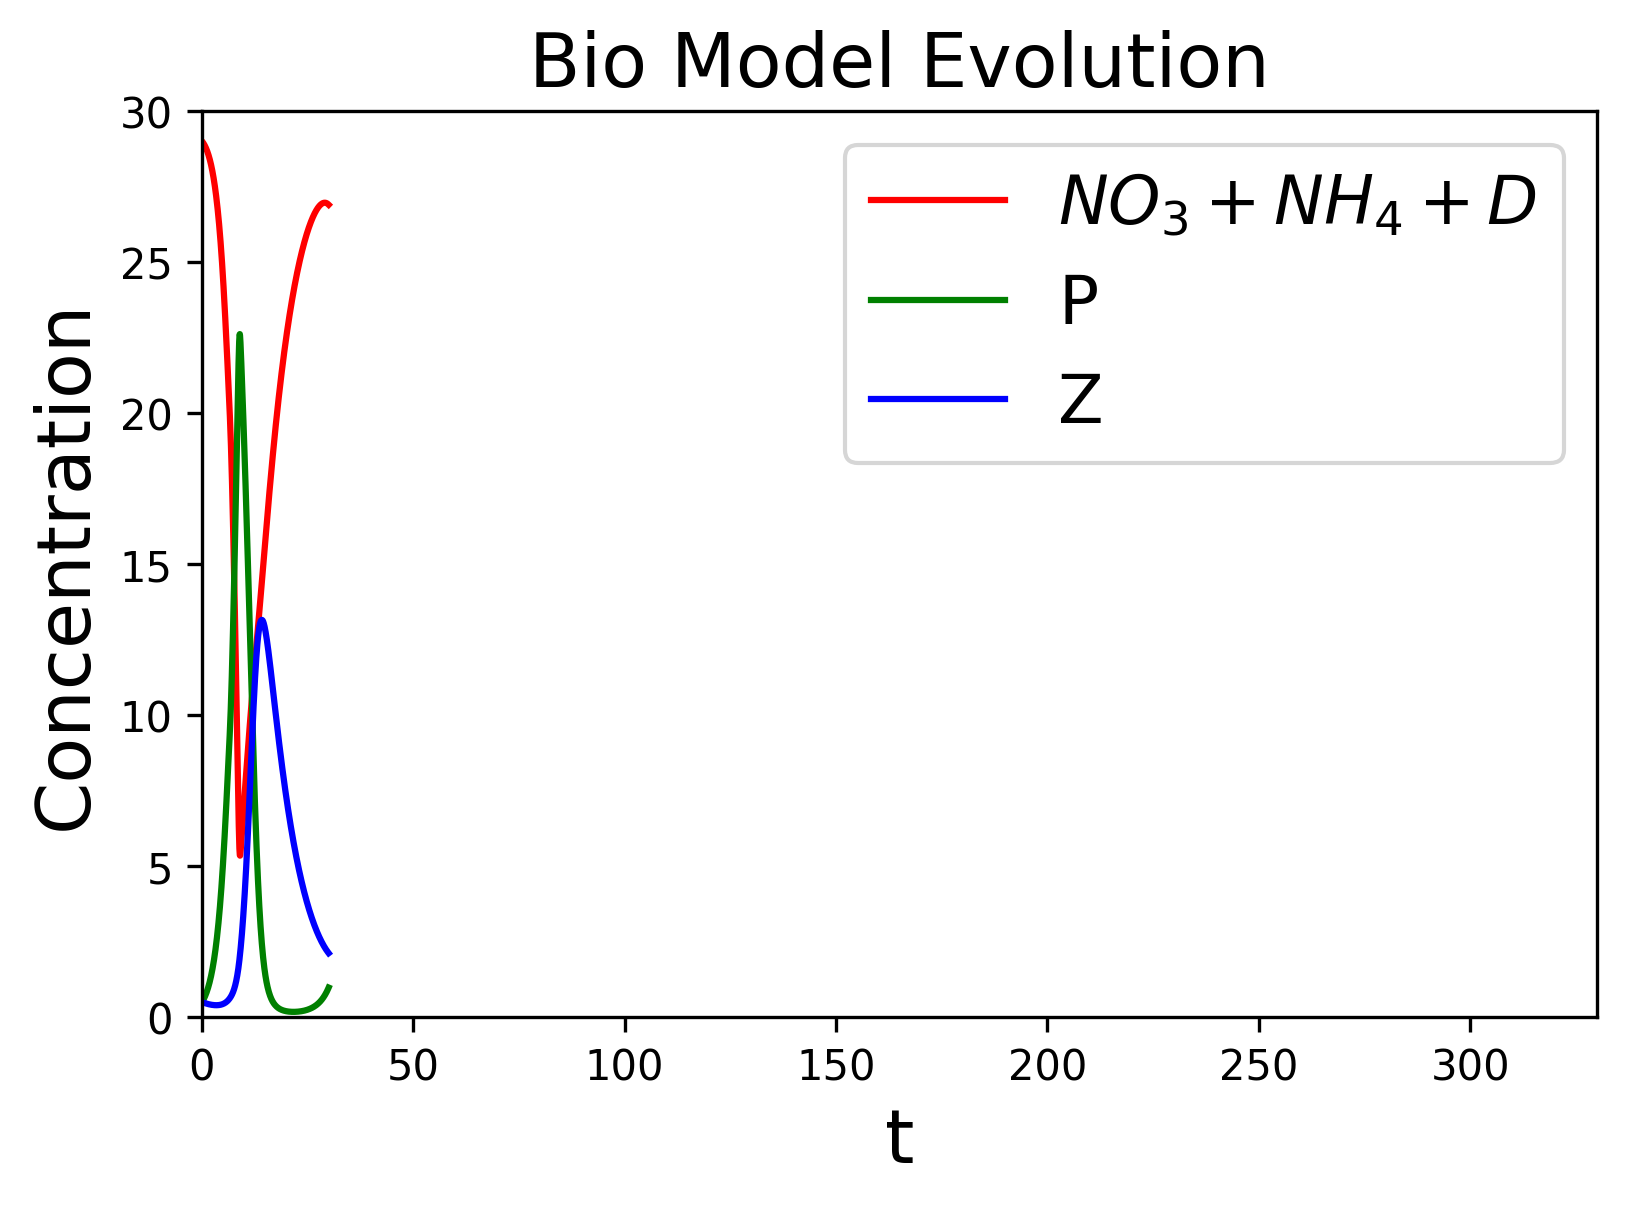

In [13]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Model Evolution', fontsize=18)
ax_x1.set_xlabel('t', fontsize=18)
ax_x1.set_ylabel('Concentration', fontsize=18)
ax_x1.plot(t.numpy()[0:int(len(t.numpy())/2)], x_nnpzd[0:int(len(t.numpy())/2), 0, 0] + x_nnpzd[0:int(len(t.numpy())/2), 0, 1] + x_nnpzd[0:int(len(t.numpy())/2), 0, 4], '-r', label = '$NO_3 + NH_4 + D$')
ax_x1.plot(t.numpy()[0:int(len(t.numpy())/2)], x_nnpzd[0:int(len(t.numpy())/2), 0, 2], '-g', label = 'P')
ax_x1.plot(t.numpy()[0:int(len(t.numpy())/2)], x_nnpzd[0:int(len(t.numpy())/2), 0, 3], '-b', label = 'Z')
# ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_xlim(t[0], 330)
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(loc="upper right", prop={'size': 16})

plt.gcf().set_dpi(300)
plt.show()